

Transfer Learning with Tensorflow-Feature Extraction



In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Activation
from tensorflow.keras import Sequential

In [8]:
import zipfile
#wget gets the file and downloads its to the colab drive
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unzip the file now, this unzips and extract all extracts it on to the google drive
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2024-05-30 15:43:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.207, 74.125.197.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   179MB/s    in 0.9s    

2024-05-30 15:43:15 (179 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [9]:
import os

for dirpath ,dirnames , filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and  {len(filenames)} images in {dirpath}")

There are 2 directories and  0 images in 10_food_classes_10_percent
There are 10 directories and  0 images in 10_food_classes_10_percent/test
There are 0 directories and  250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and  250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and  250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and  250 images in 10_food_classes_10_percent/test/steak
There are 0 directories and  250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and  250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and  250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and  250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and  250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and  250 images in 10_food_classes_10_percent/test/fried_rice
There are 

In [10]:
IMAGE_SHAPE = (224,224)
BATCH_SIZE =32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [11]:
datadir= pathlib.Path(train_dir)

class_names = np.array(sorted([item.name for item in datadir.glob("*")]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [12]:
tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)


#import data from directories and turn data into batches

train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size =32,
                                               target_size=(224,224),
                                               class_mode="categorical",
                                               seed=42)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                               batch_size =32,
                                               target_size=(224,224),
                                               class_mode="categorical",
                                               seed=42)


Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks

(things to run whilst our model trains)
Extra functionality performed during or after training

* Tracking experiments with callback
*model chedkpoint with modelcheckpint callback
*Stopping the model from training for too long which  helps stop overfitting

In [13]:
# Create Tesnorboard call back

import datetime

def createTensorBoardcallback(dir_name ,experiment_name ):

  log_dir = dir_name+ "/" +experiment_name+ "/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

  tensorBoard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"saving log files to filepath:{log_dir}")
  return tensorBoard_callback

In [14]:
## Creating models using Tensorflow hub

import tensorflow_hub as hub

#resneturl = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

resneturl_kaggle ="https://kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/1"

#efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

efficientnet_url_kaggle  = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"

In [15]:

from tensorflow.keras import layers

def create_model(model_url, num_classes=10):
  """ Takes a tensorflow urls nd creates a sequential model"""

  feature_extraction_layer = hub.KerasLayer(model_url,trainable=False,
                                 name="feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE +(3,))

  model = tf.keras.Sequential([

                  feature_extraction_layer,
                  layers.Dense(num_classes,activation="softmax",name="output_layer")
                                ])

  return model

In [16]:
## create resnet model

resnet_model = create_model(model_url = resneturl_kaggle, num_classes=10)

In [17]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [18]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=Adam(),
                     metrics=["accuracy"])


In [19]:
history_resnet = resnet_model.fit(train_data,
                 epochs=5,
                 steps_per_epoch=len(train_data),
                 validation_data= test_data,
                 validation_steps=len(test_data),
                 callbacks=[createTensorBoardcallback(dir_name="tensorflow_hub",
                                                        experiment_name="resnet50v2")])

saving log files to filepath:tensorflow_hub/resnet50v2/20240530-154322
Epoch 1/5
24/24 [==============================] - 22s 586ms/step - loss: 2.0020 - accuracy: 0.3400 - val_loss: 1.2415 - val_accuracy: 0.5940
Epoch 2/5
24/24 [==============================] - 11s 451ms/step - loss: 0.9523 - accuracy: 0.7093 - val_loss: 0.8440 - val_accuracy: 0.7308
Epoch 3/5
24/24 [==============================] - 11s 457ms/step - loss: 0.6339 - accuracy: 0.8227 - val_loss: 0.7483 - val_accuracy: 0.7556
Epoch 4/5
24/24 [==============================] - 11s 461ms/step - loss: 0.4853 - accuracy: 0.8587 - val_loss: 0.6986 - val_accuracy: 0.7700
Epoch 5/5
24/24 [==============================] - 11s 453ms/step - loss: 0.3874 - accuracy: 0.9053 - val_loss: 0.6628 - val_accuracy: 0.7840


In [22]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [21]:
def plot_loss_curves(history):
### Create the seperate loss curves for training and test sets

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))### produces the range (0,5)
  print(epochs)
  plt.plot(epochs,loss,label="training loss")
  plt.plot(epochs,val_loss, label="val loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs,accuracy,label="training accuracy")
  plt.plot(epochs,val_accuracy, label="val accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend();

range(0, 5)


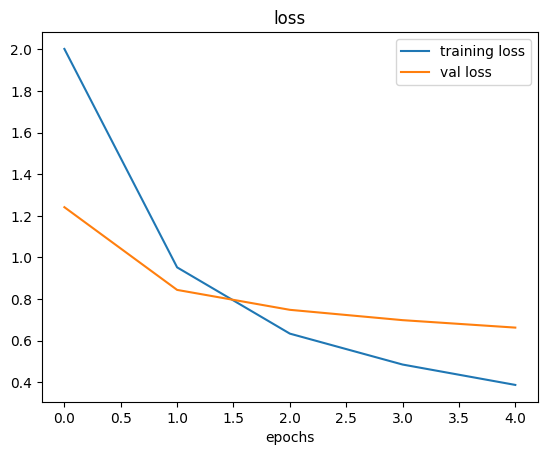

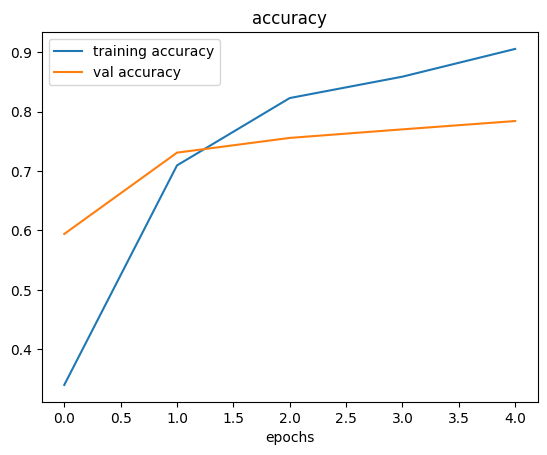

In [23]:
plot_loss_curves(history_resnet)

In [24]:
efficientNet_model = create_model(model_url = efficientnet_url_kaggle, num_classes=10)

efficientNet_model.compile(loss="categorical_crossentropy",
                     optimizer=Adam(),
                     metrics=["accuracy"])

history_efficientNet = efficientNet_model.fit(train_data,
                 epochs=5,
                 steps_per_epoch=len(train_data),
                 validation_data= test_data,
                 validation_steps=len(test_data),
                 callbacks=[createTensorBoardcallback(dir_name="tensorflow_hub",
                                                        experiment_name="efficientNetb0")])

saving log files to filepath:tensorflow_hub/efficientNetb0/20240530-154705
Epoch 1/5
24/24 [==============================] - 24s 534ms/step - loss: 1.8766 - accuracy: 0.4080 - val_loss: 1.3165 - val_accuracy: 0.7324
Epoch 2/5
24/24 [==============================] - 10s 420ms/step - loss: 1.0693 - accuracy: 0.7747 - val_loss: 0.8778 - val_accuracy: 0.8200
Epoch 3/5
24/24 [==============================] - 10s 432ms/step - loss: 0.7620 - accuracy: 0.8333 - val_loss: 0.7060 - val_accuracy: 0.8392
Epoch 4/5
24/24 [==============================] - 9s 401ms/step - loss: 0.6073 - accuracy: 0.8667 - val_loss: 0.6146 - val_accuracy: 0.8540
Epoch 5/5
24/24 [==============================] - 10s 421ms/step - loss: 0.5146 - accuracy: 0.8827 - val_loss: 0.5609 - val_accuracy: 0.8676


In [25]:
efficientNet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


range(0, 5)


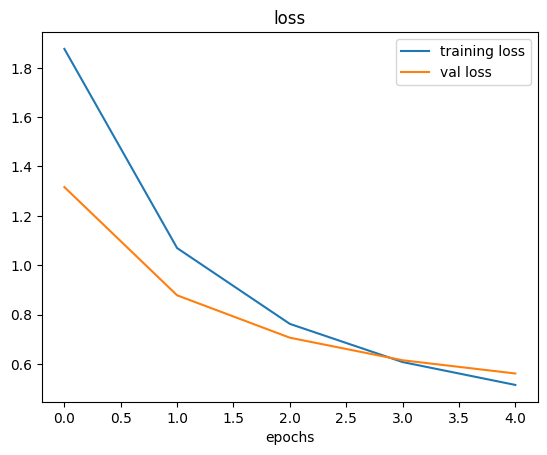

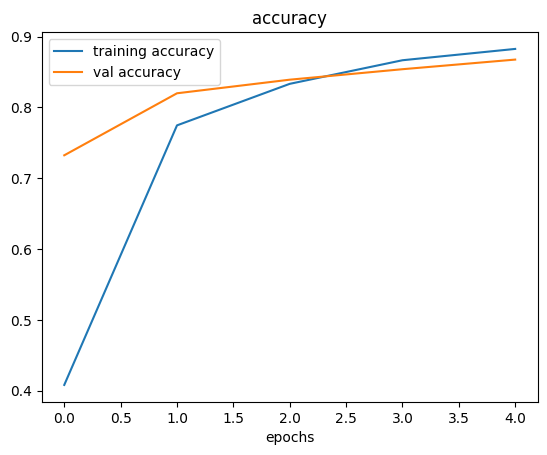

In [26]:
plot_loss_curves(history_efficientNet)